TO DO
2)Double check that tidal input files are being created in the correct directory
3)make file path generic

# Bring-your-own rotated and/or curvilinear domain 

This example is forced by GLORYS, ERA5 reanalysis datasets and TPXO tidal model

**Note**: FRE-NC tools are required to be set up, as outlined in the [documentation](https://regional-mom6.readthedocs.io/en/latest/) of regional-mom6 package.

For this example we need:

- [GEBCO bathymetry](https://www.gebco.net/data_and_products/gridded_bathymetry_data/)
- [GLORYS ocean reanalysis data](https://data.marine.copernicus.eu/product/GLOBAL_MULTIYEAR_PHY_001_030/description), and
- [ERA5 surface forcing](https://www.ecmwf.int/en/forecasts/dataset/ecmwf-reanalysis-v5)
- [TPXO tidel model](https://www.tpxo.net/global)

This example reads in the entire global extent of ERA5, GEBCO and TPXO; we don't need to worry about cutting it down to size.
This example requires you to bring your own mom-6 compatible model domain input netcdf file called hgrid.nc. This regional mom-6 toolbox can cope with regular, rotated and curvilinear model domains.  

Note that this notebook includes some example plots and you will need matplotlib for the plots to work

In [1]:
import regional_mom6 as rmom6

import os
from pathlib import Path
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:36165/status,
Dashboard: http://127.0.0.1:36165/status,Workers: 7
Total threads: 7,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44181,Workers: 7
Dashboard: http://127.0.0.1:36165/status,Total threads: 7
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:39149,Total threads: 1
Dashboard: http://127.0.0.1:42227/status,Memory: 4.57 GiB
Nanny: tcp://127.0.0.1:41021,


## Step 1: Choose our domain, define workspace paths

To make sure that things are working I'd recommend starting with a small domain. If this runs ok, then change to the domain of your choice and hopefully it runs ok too! If not, check the [README](https://github.com/COSIMA/regional-mom6/blob/main/README.md) and [documentation](https://regional-mom6.readthedocs.io/) for troubleshooting tips.



In [2]:
expt_name = "rotated-demo5"

#latitude_extent = [16., 27]
#longitude_extent = [192, 209] #fill will nones and test these are optional so remove

date_range = ["2020-01-01 00:00:00", "2020-02-01 00:00:00"]

## Place where all your input files go 
input_dir = Path(f"/scratch/tm70/hm6113/regional_ncar/{expt_name}/")

## Directory where you'll run the experiment from
run_dir = Path(f"/scratch/tm70/hm6113/regional_ncar/{expt_name}/")

## Directory where compiled FRE tools are located (needed for construction of mask tables)
toolpath_dir = Path("/g/data/tm70/hm6113/repo/FRE-NCtools")

## Path to where your raw ocean forcing files are stored
glorys_path = Path(f"/g/data/tm70/hm6113/glorys/{expt_name}" )

#Directory where the ERA raw atmospheric output files are stored
era_path = Path("/g/data/rt52/era5/single-levels/reanalysis")

#Location of TPXO raw tidal file
tide_h_path = Path("/g/data/tm70/hm6113/tides/DATA/h_tpxo10.v2.nc")
tide_u_path = Path("/g/data/tm70/hm6113/tides/DATA/u_tpxo10.v2.nc")

#location of the BYO hgrid file
byogrid_path = "/scratch/tm70/hm6113/regional_ncar/rotated-demo/hgrid.nc"

#location to where your bathymetry data is stored
bathy_path = Path("/scratch/tm70/hm6113/GEBCO_2024.nc")

## if directories don't exist, create them
for path in (run_dir, glorys_path, input_dir):
    os.makedirs(str(path), exist_ok=True)


In [3]:
##Copy hgrid.nc into the experinment folder
import shutil
shutil.copy2(byogrid_path,input_dir)

'/scratch/tm70/hm6113/regional_ncar/rotated-demo5/hgrid.nc'

## Step 2: Make experiment object
The `regional_mom6.experiment` contains the regional domain basics, and also generates the horizontal and vertical grids, `hgrid` and `vgrid` respectively, and sets up the directory structures. 

In [4]:
expt = rmom6.experiment(
    date_range = date_range,
    resolution = 0.5,
    number_vertical_layers = 75,
    layer_thickness_ratio = 100,
    depth = 4500,
    minimum_depth = 5,
    mom_run_dir = run_dir,
    mom_input_dir = input_dir,
    toolpath_dir = toolpath_dir,
    hgrid_type = 'from_file',
    boundaries = ['north','south','east','west']
)


We can now access the horizontal and vertical grid of the regional configuration via `expt.hgrid` and `expt.vgrid` respectively.

Plotting the vertical grid with `marker = '.'` lets you see the spacing. You can use `numpy.diff` to compute the vertical spacings, e.g.,
```python
import numpy as np
np.diff(expt.vgrid.zl).plot(marker = '.')
```
shows you the vertical spacing profile.

### Modular workflow!

After constructing your `expt` object, if you don't like the default `hgrid` and `vgrid` you can simply modify and then save them back into the `expt` object. However, you'll then also need to save them to disk again. For example:

```python
new_hgrid = xr.open_dataset(input_dir + "/hgrid.nc")
```
Modify `new_hgrid`, ensuring that _all metadata_ is retained to keep MOM6 happy. Then, save your changes

```python
expt.hgrid = new_hgrid

expt.hgrid.to_netcdf(input_dir + "/hgrid.nc")
```

## Step 3: Prepare ocean forcing data

We need to cut out our ocean forcing. The package expects an initial condition and one time-dependent segment per non-land boundary. Naming convention is `"east_unprocessed"` for segments and `"ic_unprocessed"` for the initial condition.

In this notebook, we are forcing with the Copernicus Marine "Glorys" reanalysis dataset. There's a function in the `mom6-regional` package that generates a bash script to download the correct boundary forcing files for your experiment. First, you will need to create an account with Copernicus, and then call `copernicusmarine login` to set up your login details on your machine. Then you can run the `get_glorys_data.sh` bash script.

This bash script uses the [Capernicus marine toolbox]( https://help.marine.copernicus.eu/en/articles/7970514-copernicus-marine-toolbox-installation) and users should install this before running the bash script.


In [5]:
expt.get_glorys(
    raw_boundaries_path=glorys_path
)

The script `get_glorys_data.sh` has been generated at:
  /g/data/tm70/hm6113/glorys/rotated-demo5.
To download the data, run this script using `bash` in a terminal with internet access.

Important instructions:
1. You will need your Copernicus Marine username and password.
   If you do not have an account, you can create one here: 
   https://data.marine.copernicus.eu/register
2. You will be prompted to enter your Copernicus Marine credentials multiple times: once for each dataset.
3. Depending on the dataset size, the download process may take significant time and resources.
4. Thus, on certain systems, you may need to run this script as a batch job.



## Step 4: Set up bathymetry

Similarly to ocean forcing, we point the experiment's `setup_bathymetry` method at the location of the file of choice and also provide the variable names. We don't need to preprocess the bathymetry since it is simply a two-dimensional field and is easier to deal with. Afterwards you can inspect `expt.bathymetry` to have a look at the regional domain.

After running this cell, your input directory will contain other bathymetry-related things like the ocean mosaic and mask table too. The mask table defaults to a 10x10 layout and can be modified later.

In [6]:
expt.setup_bathymetry(
    bathymetry_path=bathy_path,
    longitude_coordinate_name="lon",
    latitude_coordinate_name="lat",
    vertical_coordinate_name="elevation",
)

Begin regridding bathymetry...

Original bathymetry size: 9.96 Mb
Regridded size: 0.06 Mb
Automatic regridding may fail if your domain is too big! If this process hangs or crashes,open a terminal with appropriate computational and resources try calling ESMF directly in the input directory /scratch/tm70/hm6113/regional_ncar/rotated-demo5 via

`mpirun -np NUMBER_OF_CPUS ESMF_Regrid -s bathymetry_original.nc -d bathymetry_unfinished.nc -m bilinear --src_var depth --dst_var depth --netcdf4 --src_regional --dst_regional`

For details see https://xesmf.readthedocs.io/en/latest/large_problems_on_HPC.html

Afterwards, we run the 'expt.tidy_bathymetry' method to skip the expensive interpolation step, and finishing metadata, encoding and cleanup.



Regridding successful! Now calling `tidy_bathymetry` method for some finishing touches...
Tidy bathymetry: Reading in regridded bathymetry to fix up metadata...done. Filling in inland lakes and channels... done.
setup bathymetry has finished successf

<xarray.Dataset>
Dimensions:  (ny: 49, nx: 49)
Coordinates:
    lat      (ny, nx) float64 55.67 55.67 55.68 55.68 ... 58.31 58.32 58.32
    lon      (ny, nx) float64 -41.52 -41.43 -41.34 ... -37.72 -37.63 -37.53
Dimensions without coordinates: ny, nx
Data variables:
    depth    (ny, nx) float64 3.16e+03 3.271e+03 ... 3.192e+03 3.195e+03
Attributes:
    regrid_method:  bilinear
    depth:          meters
    standard_name:  bathymetric depth at T-cell centers
    coordinates:    zi

### Check out your domain: 
Calling expt.bathymetry returns an xarray dataset, which can be plotted as usual. If you haven't yet run setup_bathymetry, calling expt.bathymetry will return None and prompt you to do so!

We do 2 different plots, the first is in x and y coordinates and will look rectangular. The second is in lat and lon coordinates and will show the shape of the curvilinear/rotated domain.

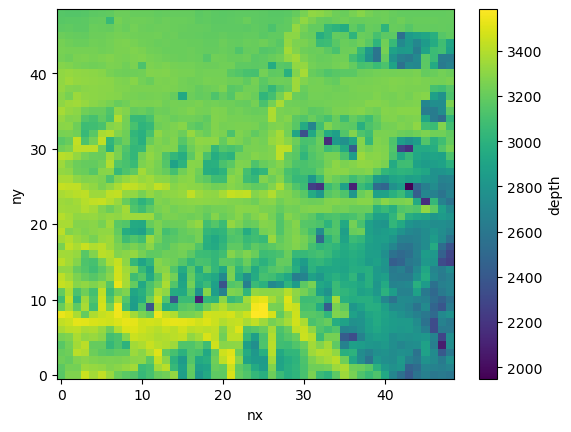

In [7]:
#In x/y coords
expt.bathymetry.depth.plot()

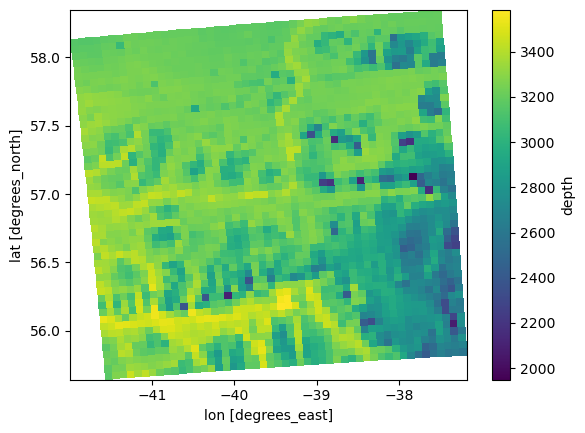

In [8]:
#In lat/lon coords
import xarray as xr
bathy = xr.open_dataset(run_dir / "bathymetry.nc")
bathy.depth.plot(x="lon",y="lat")


##  Step 5: Handle the ocean forcing - where the magic happens

This cuts out and interpolates the initial condition as well as all boundaries (unless you don't pass it boundaries).

The dictionary maps the MOM6 variable names to what they're called in your ocean input file. Notice how for GLORYS, the horizontal dimensions are `latitude` and `longitude`, vs `xh`, `yh`, `xq`, `yq` for MOM6. This is because for an 'A' grid type tracers share the grid with velocities so there's no difference.

If one of your segments is land, you can delete its string from the 'boundaries' list. You'll need to update MOM_input to reflect this though so it knows how many segments to look for, and their orientations.

In [9]:
# Define a mapping from the GLORYS variables and dimensions to the MOM6 ones
ocean_varnames = {"time": "time",
                  "yh": "latitude",
                  "xh": "longitude",
                  "zl": "depth",
                  "eta": "zos",
                  "u": "uo",
                  "v": "vo",
                  "tracers": {"salt": "so", "temp": "thetao"}
                  }

# Set up the initial condition
expt.setup_initial_condition(
    glorys_path / "ic_unprocessed.nc", # directory where the unprocessed initial condition is stored, as defined earlier
    ocean_varnames,
    arakawa_grid="A"
    )    

# Set up the four boundary conditions. Remember that in the glorys_path, we have four boundary files names north_unprocessed.nc etc. 
expt.setup_ocean_state_boundaries(
        glorys_path,
        ocean_varnames,
        arakawa_grid = "A"
        )


Setting up Initial Conditions
Regridding Velocities... Done.
Regridding Tracers... Done.
Regridding Free surface... Done.
Saving outputs... done setting up initial condition.
Processing north boundary velocity & tracers...

All NaNs filled b/c bathymetry wasn't provided to the function. Add bathymetry_path to the segment class to avoid this
All NaNs filled b/c bathymetry wasn't provided to the function. Add bathymetry_path to the segment class to avoid this


Done.
Processing south boundary velocity & tracers...

All NaNs filled b/c bathymetry wasn't provided to the function. Add bathymetry_path to the segment class to avoid this


Done.
Processing east boundary velocity & tracers...

All NaNs filled b/c bathymetry wasn't provided to the function. Add bathymetry_path to the segment class to avoid this


Done.
Processing west boundary velocity & tracers...Done.


### Check out your initial condition data

Text(0.5, 1.0, 'lon/lat coords')

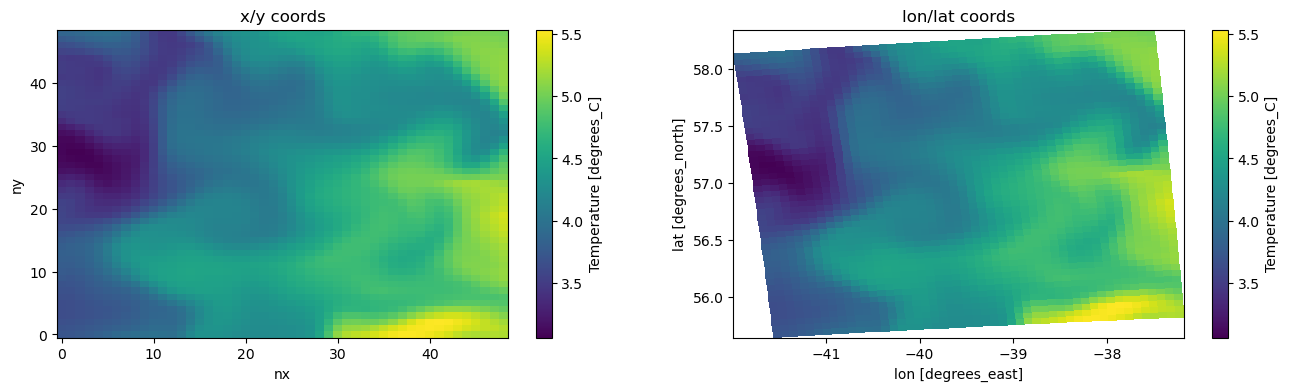

In [10]:
## Preview the initial temperature at the surface in x/y and lat/lon coordinates
from matplotlib import pyplot as plt
##Creating a new temperature array with lat and lon coords
templatlon = expt.init_tracers.temp.assign_coords(lon=bathy.lon,lat=bathy.lat)

#plotting
fig, axes = plt.subplots(ncols=2, figsize=(16,4))
templatlon.isel(zl=0).plot(ax=axes[0])
templatlon.isel(zl=0).plot(x="lon",y="lat",ax=axes[1])
axes[0].set_title("x/y coords")
axes[1].set_title("lon/lat coords")


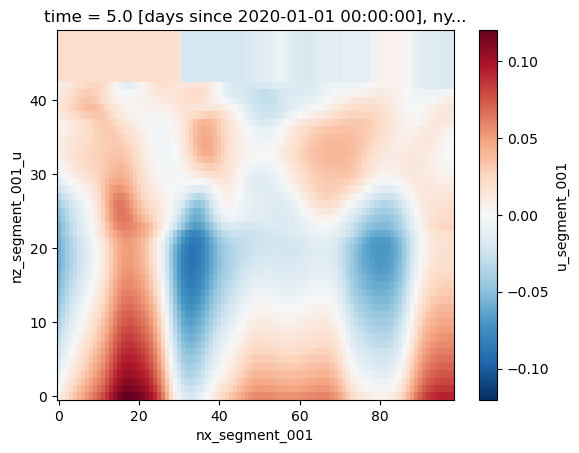

In [11]:
## u boundary forcing for segment 1 (south)
expt.segment_001.u_segment_001.isel(time = 5).plot()


### Step 6: Create Tidal forcing
For rectangluar domains (boundaries are aligned with lats and longs) you can use :
boundary_type="rectangular"

Note that this step can take a while (5 mins +). 

In [13]:
expt.setup_boundary_tides(
        tide_h_path,
        tide_u_path,
        tidal_constituents=["M2"],
        boundary_type="curvilinear"
)

Processing north boundary...

All NaNs filled b/c bathymetry wasn't provided to the function. Add bathymetry_path to the segment class to avoid this
All NaNs filled b/c bathymetry wasn't provided to the function. Add bathymetry_path to the segment class to avoid this


Done
Processing south boundary...

All NaNs filled b/c bathymetry wasn't provided to the function. Add bathymetry_path to the segment class to avoid this
All NaNs filled b/c bathymetry wasn't provided to the function. Add bathymetry_path to the segment class to avoid this


Done
Processing east boundary...

All NaNs filled b/c bathymetry wasn't provided to the function. Add bathymetry_path to the segment class to avoid this
All NaNs filled b/c bathymetry wasn't provided to the function. Add bathymetry_path to the segment class to avoid this


Done
Processing west boundary...

All NaNs filled b/c bathymetry wasn't provided to the function. Add bathymetry_path to the segment class to avoid this
All NaNs filled b/c bathymetry wasn't provided to the function. Add bathymetry_path to the segment class to avoid this


Done


## Step 7: Run the FRE tools

This is just a wrapper for the FRE tools needed to make the mosaics and masks for the experiment. The only thing you need to tell it is the processor layout. In this case we're saying that we want a 10 by 10 grid of 100 processors. 

In [14]:
expt.run_FRE_tools(layout=(10, 10)) ##the tiling/no processors

Running GFDL's FRE Tools. The following information is all printed by the FRE tools themselves
i=0, yb1=58.1331888751, yb2=58.3479205820, dy= 0.2147317068
NOTE from make_solo_mosaic: there are 0 contacts (align-contact)
congratulation: You have successfully run make_solo_mosaic
OUTPUT FROM MAKE SOLO MOSAIC:

CompletedProcess(args='/g/data/tm70/hm6113/repo/FRE-NCtools/make_solo_mosaic/make_solo_mosaic --num_tiles 1 --dir . --mosaic_name ocean_mosaic --tile_file hgrid.nc', returncode=0)


cp: './ocean_mosaic.nc' and 'ocean_mosaic.nc' are the same file
cp: './hgrid.nc' and 'hgrid.nc' are the same file


cp ./hgrid.nc hgrid.nc 

NOTE from make_coupler_mosaic: the ocean land/sea mask will be determined by field depth from file bathymetry.nc
mosaic_file is grid_spec.nc

***** Congratulation! You have successfully run make_quick_mosaic
OUTPUT FROM QUICK MOSAIC:

CompletedProcess(args='/g/data/tm70/hm6113/repo/FRE-NCtools/make_quick_mosaic/make_quick_mosaic --input_mosaic ocean_mosaic.nc --mosaic_name grid_spec --ocean_topog bathymetry.nc', returncode=0)

 ===>NOTE from check_mask: when layout is specified, min_pe and max_pe is set to layout(1)*layout(2)=100

 ===>NOTE from check_mask: Below is the list of command line arguments.

grid_file = ocean_mosaic.nc
model = ocean
topog_file = bathymetry.nc
min_pe = 100
max_pe = 100
layout = 10, 10
halo = 4
sea_level = 0
show_valid_only is not set
nobc = 0

 ===>NOTE from check_mask: End of command line arguments.

 ===>NOTE from check_mask: the grid file is version 2 (solo mosaic grid) grid which contains field gridfiles

==>NOTE from get_boundary

## Step 8: Set up ERA5 forcing:

Here we assume the ERA5 dataset is stored somewhere on the system we are working on. 

Below is a table showing ERA5 characteristics and what needs to be done to sort it out.

**Required ERA5 data**:

Name | ERA5 filename | ERA5 variable name | Units
---|---|---|---
Surface Pressure | sp | sp | Pa 
Surface Temperature | 2t | t2m | K 
Meridional Wind | 10v | v10 | m/s 
Zonal Wind | 10u | u10 | m/s 
Specific Humidity | - | - | kg/kg, calculated from dewpoint temperature
Dewpoint Temperature | 2d | d2m | K


We calculate specific humidity $q$ from dewpoint temperature $T_d$ and surface pressure $P$ via saturation vapour pressure $P_v$.

$$P_v = 10^{8.07131 - \frac{1730.63}{233.426 + T}} \frac{101325}{760} \; \textrm{[Pascal]} $$

$$q = 0.001 \times 0.622  \frac{P_v}{P}$$

In [15]:
expt.setup_era5(era_path)

## Step 8: Modify the default input directory to make a (hopefully) runnable configuration out of the box

This step copies the default directory and modifies the `MOM_layout` files to match your experiment by inserting the right number of x, y points and CPU layout.

To run MOM6 using the [payu infrastructure](https://github.com/payu-org/payu), provide the keyword argument `using_payu = True` to the `setup_run_directory` method and an example `config.yaml` file will be appear in the run directory. The `config.yaml` file needs to be modified manually to add the locations of executables, etc.

In [16]:
expt.setup_run_directory(surface_forcing = "era5",using_payu = True, with_tides = True) 

Could not find premade run directories at  /scratch/tm70/hm6113/code/rm6_helen_update/regional-mom6/regional_mom6/demos/premade_run_directories
Perhaps the package was imported directly rather than installed with conda. Checking if this is the case... Found run files. Continuing...
No mask table found, but the cpu layout has been set to (10, 10) This suggests the domain is mostly water, so there are no `non compute` cells that are entirely land. If this doesn't seem right, ensure you've already run the `FRE_tools` method which sets up the cpu mask table. Keep an eye on any errors that might print whilethe FRE tools (which run C++ in the background) are running.
Number of CPUs required:  100
Deleting indexed OBC keys from MOM_input_dict in case we have a different number of segments
Changed OBC_TIDE_REF_DATE from 2020, 1, 1 to 2020, 01, 01in MOM_override!
